In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
from sklearn.metrics import average_precision_score
import seaborn as sns
from tqdm import tqdm

In [5]:
dataset = "de_novo_v1"

models = [
    "phyloP-100v",
    "phyloP-241m",
    "phastCons-43p",
]

V = pl.read_parquet(f"../../results/dataset/{dataset}/test.parquet")
for model in models:
    V = V.with_columns(
        pl.read_parquet(f"../../results/dataset/{dataset}/features/{model}.parquet")["score"].alias(model)
    )
V

chrom,pos,ref,alt,OMIM,consequence,maf,label,AF,phyloP-100v,phyloP-241m,phastCons-43p
str,i64,str,str,str,str,f64,bool,f64,f64,f64,f64
"""21""",41420748,"""A""","""C""",null,"""5_prime_UTR_variant""",null,false,null,-0.098,-0.654,0.001
"""21""",33403502,"""G""","""C""",null,"""5_prime_UTR_variant""",null,false,null,0.631,-0.128,0.0
"""21""",46459040,"""G""","""C""",null,"""5_prime_UTR_variant""",null,false,null,-2.763,-0.965,0.002
"""21""",33026399,"""G""","""A""",null,"""5_prime_UTR_variant""",null,false,null,-0.221,0.872,0.601
"""21""",45277274,"""T""","""G""",null,"""5_prime_UTR_variant""",null,false,null,-3.223,-1.595,0.0
…,…,…,…,…,…,…,…,…,…,…,…
"""21""",33633700,"""A""","""T""",null,"""5_prime_UTR_variant""",null,false,null,0.031,0.271,0.03
"""21""",37366175,"""C""","""A""",null,"""5_prime_UTR_variant""",null,false,null,-3.894,0.705,0.095
"""21""",10524636,"""A""","""G""",null,"""5_prime_UTR_variant""",null,false,null,-1.379,-1.802,0.004


In [6]:
# TODO: should be careful about setting nan = 0 for conservation methods
V.group_by("label").agg(pl.mean(models))

label,phyloP-100v,phyloP-241m,phastCons-43p
bool,f64,f64,f64
false,0.068617,0.388056,0.256159
true,2.719247,3.819494,0.731481


In [68]:
def odds_ratio_score(y_true, y_pred, threshold_q=0.05):
    df = pl.DataFrame({"label": y_true, "score": -y_pred})
    threshold = df.select(pl.col("score").quantile(threshold_q))["score"]
    # TODO: need to decide how to handle ties... they are certainly an issue with phastCons
    #print((df["score"] <= threshold).sum())
    group_counts = (
        df.group_by(["label", pl.col("score") <= threshold]).len()
        .sort(["label", "score"])["len"].to_numpy().reshape((2,2))
    )
    res = odds_ratio(group_counts, kind="sample")
    ci = res.confidence_interval(confidence_level=0.95)
    return res.statistic, ci.low, ci.high

In [69]:
res = []
for model in tqdm(models):
    y_true = V["label"]
    y_pred = V[model]
    res.append((
        model,
        average_precision_score(y_true, y_pred),
        odds_ratio_score(y_true, y_pred, 0.01),
        odds_ratio_score(y_true, y_pred, 0.05),
        odds_ratio_score(y_true, y_pred, 0.1),
    ))
res = pd.DataFrame(res, columns=["model", "AUPRC", "OR@1%", "OR@5%", "OR@10%"])
res

100%|██████████| 3/3 [00:00<00:00,  8.67it/s]


,model,AUPRC,OR@1%,OR@5%,OR@10%
0,phyloP-100v,0.061871,"(37.217224076870465, 22.773050958881097, 60.82...","(16.82628233899075, 10.872042360273152, 26.041...","(9.23016157811261, 5.969729331878633, 14.27131..."
1,phyloP-241m,0.003088,"(24.46982766537084, 14.140572301576428, 42.344...","(20.52549120328753, 13.269291222292624, 31.749...","(12.457466548100015, 8.011360205618917, 19.371..."
2,phastCons-43p,0.001162,"(3.1622199062011465, 1.5809439986982017, 6.325...","(6.328862066298912, 3.948824829426192, 10.1433...","(7.818536764225399, 5.052719135221658, 12.0983..."


In [70]:
# Reshape the data from wide to long format for plotting using pandas.melt
res_long = res.melt(
    id_vars="model",
    value_vars=["OR@1%", "OR@5%", "OR@10%"],
    var_name="%",
    value_name="OR_CI",
)

# Extract OR and CI values into separate columns
# The .str accessor provides an efficient way to split tuples in a Series
res_long['OR'] = res_long['OR_CI'].str[0]
res_long['ci_low'] = res_long['OR_CI'].str[1]
res_long['ci_high'] = res_long['OR_CI'].str[2]
res_long

,model,%,OR_CI,OR,ci_low,ci_high
0,phyloP-100v,OR@1%,"(37.217224076870465, 22.773050958881097, 60.82...",37.217224,22.773051,60.822846
1,phyloP-241m,OR@1%,"(24.46982766537084, 14.140572301576428, 42.344...",24.469828,14.140572,42.344288
2,phastCons-43p,OR@1%,"(3.1622199062011465, 1.5809439986982017, 6.325...",3.162220,1.580944,6.325104
3,phyloP-100v,OR@5%,"(16.82628233899075, 10.872042360273152, 26.041...",16.826282,10.872042,26.041453
4,phyloP-241m,OR@5%,"(20.52549120328753, 13.269291222292624, 31.749...",20.525491,13.269291,31.749683
5,phastCons-43p,OR@5%,"(6.328862066298912, 3.948824829426192, 10.1433...",6.328862,3.948825,10.143396
6,phyloP-100v,OR@10%,"(9.23016157811261, 5.969729331878633, 14.27131...",9.230162,5.969729,14.271314
7,phyloP-241m,OR@10%,"(12.457466548100015, 8.011360205618917, 19.371...",12.457467,8.011360,19.371052
8,phastCons-43p,OR@10%,"(7.818536764225399, 5.052719135221658, 12.0983...",7.818537,5.052719,12.098341


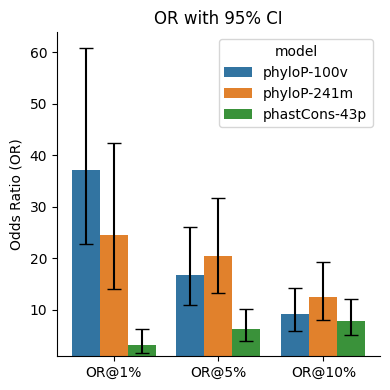

In [74]:
# 1. Create the bar plot
plt.figure(figsize=(4, 4))
ax = sns.barplot(data=res_long, x="%", y="OR", hue="model")

# 2. Add custom error bars robustly
for bar in ax.patches:
    # Get the bar's color to identify its hue
    bar_color = bar.get_facecolor()
    
    # Get the x-tick label for the bar
    x_tick_label = ax.get_xticklabels()[int(round(bar.get_x() + bar.get_width() / 2))].get_text()

    # Get the handles for the legend
    legend_handles, _ = ax.get_legend_handles_labels()
    
    hue_label = ""
    for handle in legend_handles:
        # --- THIS IS THE FIXED LINE ---
        # We look at the color of the first patch *inside* the BarContainer
        if handle.patches[0].get_facecolor() == bar_color:
            hue_label = handle.get_label()
            break

    # Find the corresponding data row in the DataFrame
    data_row = res_long[(res_long['model'] == hue_label) & (res_long['%'] == x_tick_label)]
    
    if data_row.empty:
        continue

    # Extract data from the correctly identified row
    ci_low = data_row['ci_low'].iloc[0]
    ci_high = data_row['ci_high'].iloc[0]
    
    # Use the bar's actual height for y-position and calculation
    bar_height = bar.get_height()
    
    # Calculate error bar magnitudes
    lower_error = bar_height - ci_low
    upper_error = ci_high - bar_height
    
    # Ensure errors are positive
    if lower_error < 0: lower_error = 0
    if upper_error < 0: upper_error = 0
        
    # Get the x-coordinate for the error bar
    x_coord = bar.get_x() + bar.get_width() / 2
    
    # Plot the correctly aligned error bar
    ax.errorbar(x=x_coord, y=bar_height, yerr=[[lower_error], [upper_error]],
                fmt='none',
                c='black',
                capsize=5)
ax.set(ylim=1)

# --- Final Touches ---
ax.set_title("OR with 95% CI")
ax.set_ylabel("Odds Ratio (OR)")
ax.set_xlabel("")
sns.despine()
plt.tight_layout()
plt.show()